<br>
<br>
<br>
<h1><center>Assignment 03</center></h1>
<h2><center>Exploratory Data Analysis</center></h2>
<h4><center>[ISYS2047] Information Systems Solutions and Design</center></h4>
<h3><center>Part 4. Classification using Random Forest</center></h3>
<br>
<div style="text-align: right"><h4>Student name: Juyeon Kim</h4></div>
<div style="text-align: right"><h4>Student ID: S3741327</h4></div>
<br></br>

## Import libraries

In [1]:
# Library for pickling
import joblib

# Library needed for counting categorical values
import collections

# Library for splitting the data into train and test sets
from sklearn.model_selection import train_test_split 

# Model library
from sklearn.ensemble import RandomForestClassifier

# Scaling
from sklearn.preprocessing import StandardScaler

# label encoder
from sklearn.preprocessing import LabelEncoder

# Onehot encoding
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np

# Metrics library
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Binary classification using Random Forest

## 1. Load data

In [2]:
loan_df = pd.read_csv("personal-loan.csv")
loan_df.head()

,customer_id,age,yrs_experience,family_size,education_level,income,mortgage_amt,credit_card_acct,credit_card_spend,share_trading_acct,fixed_deposit_acct,online_acct,personal_loan
0,3815,40.0,9.0,3.0,Graduate,60.0,0,yes,1.7,0,0,yes,no
1,5737,65.0,27.0,4.0,Advanced or Professional,36.0,90,no,0.0,0,0,yes,no
2,4209,61.0,3.0,2.0,Undergraduate,145.0,314,no,0.0,0,1,yes,yes
3,4734,29.0,14.0,1.0,Undergraduate,52.0,0,no,0.0,1,0,yes,no
4,2551,43.0,23.0,4.0,Graduate,33.0,0,no,0.0,0,0,yes,no


In [3]:
# Load the pickled file
loan_df = joblib.load('loan-cleaned.pkl')  

# Check
loan_df.head()

,customer_id,age,yrs_experience,family_size,education_level,income,mortgage_amt,credit_card_acct,credit_card_spend,share_trading_acct,fixed_deposit_acct,online_acct,personal_loan
0,3815.0,40.0,9.0,3.0,2.0,60.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,5737.0,65.0,27.0,4.0,1.0,36.0,90.0,0.0,0.0,0.0,0.0,1.0,0
2,4209.0,61.0,3.0,2.0,0.0,145.0,0.0,0.0,0.0,0.0,1.0,1.0,1
3,4734.0,29.0,14.0,1.0,0.0,52.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,2551.0,43.0,23.0,4.0,2.0,33.0,0.0,0.0,0.0,0.0,0.0,1.0,0


## 2. Split cleaned data into training and testing sets

In [4]:
feature_cols = [ # fullsets
    'age', 
    'yrs_experience', 
    'family_size',
    'education_level', 
    'income', 
    'mortgage_amt', 
    'credit_card_acct',
    'credit_card_spend', 
    'share_trading_acct', 
    'fixed_deposit_acct',
    'online_acct'
]

X = loan_df[feature_cols]
# print('X:\n', X)

# Store the labels/target in variable y (lower case as its a single value)
y = loan_df['personal_loan']
# print('y:\n', y)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # keep 20% for testing
                                                    random_state=2 # pass an int for reproducible result
                                                    )

## 2.2 Data Transformation

#### a. Discretization of continuous variables

> - Can be applied to Decision trees which prefer categorical/ordinal input variables.
> - to change a continuous variable to discrete categories
> - is also used for changing the distribution of variables that are not normally distributed

> - From section 3.2.2 Visualization of continuous variables on "01-assign3-eda" file, we've identified "mortgage_amt" and "credit_card_spend" aren't normally distributed. 
> - So, those 2 variables shall be discreted. 


#### a.1. mortgage_amt

> ***Result***
> - There is no distinct standard to divide up the amount of mortage into categories. 
> - According to Average Australian mortgage statistics, average size of mortgage is 553,897 dollars per year on 2021, 
however, those figure is far beyond the max-value of mortgate_amt which is $312k. 

> - So I ended up categorizing the values with the use of descriptive analysis
> - 1. value with 0: mg_no
> - 2. top 20% value (between 0 and 97): mg_low
> - 2. top 75% value (between 97 and 177):  mg_moderate
> - 3. beyond: mg_high


> - Reference: https://www.finder.com.au/australian-home-loan-statistics

In [5]:
# Descriptive analysis on mortgate_amt (excluding value 0)
loan_df[loan_df.mortgage_amt > 0]['mortgage_amt'].describe().T

count    2621.000000
mean      143.225105
std        56.868870
min        70.000000
25%        97.000000
50%       130.000000
75%       177.000000
max       312.000000
Name: mortgage_amt, dtype: float64

In [6]:
# Pass the whole dataframe as parameter
def mg_category(df): 
    if df["mortgage_amt"] == 0:
        return "mg_no"
    
    elif (df["mortgage_amt"] > 0) & (df["mortgage_amt"] <= 97):
        return "mg_low"
    
    elif (df["mortgage_amt"] > 97) & (df["mortgage_amt"] <= 177):
        return "mg_moderate"
    
    elif df["mortgage_amt"] > 177:
        return "mg_moderate"

In [7]:
# Apply the  previously defined function to the training set
X_train = X_train.copy()
X_train["mortgage_amt_category"] = \
    X_train.apply(lambda X_train:mg_category(X_train), axis = 1) # axis=1 = row-wise

# The column "mortgage_amt" is no longer needed and hence can be deleted 
X_train.drop(['mortgage_amt'], axis=1, inplace=True)

# Check
X_train.head()

,age,yrs_experience,family_size,education_level,income,credit_card_acct,credit_card_spend,share_trading_acct,fixed_deposit_acct,online_acct,mortgage_amt_category
2973,63.0,11.0,1.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,mg_no
2774,35.0,39.0,4.0,0.0,144.0,0.0,0.0,0.0,0.0,1.0,mg_no
3281,34.0,38.0,2.0,1.0,55.0,1.0,0.2,0.0,0.0,1.0,mg_no
2512,62.0,12.0,1.0,0.0,94.0,0.0,0.0,0.0,0.0,1.0,mg_no
457,57.0,32.0,4.0,2.0,70.0,0.0,0.0,0.0,0.0,1.0,mg_no


In [8]:
# Apply the  previously defined function to the testing set
X_test = X_test.copy()
X_test["mortgage_amt_category"] = \
    X_test.apply(lambda X_test:mg_category(X_test), axis = 1) # axis=1 = row-wise

# The column "mortgage_amt" is no longer needed and hence can be deleted 
X_test.drop(['mortgage_amt'], axis=1, inplace=True)

# Check
X_test.head()

,age,yrs_experience,family_size,education_level,income,credit_card_acct,credit_card_spend,share_trading_acct,fixed_deposit_acct,online_acct,mortgage_amt_category
1637,61.0,27.0,1.0,2.0,20.0,1.0,0.0,0.0,0.0,0.0,mg_moderate
1381,23.0,32.0,1.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,mg_moderate
2714,26.0,7.0,1.0,1.0,83.0,0.0,0.0,0.0,0.0,0.0,mg_moderate
2556,34.0,27.0,2.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,mg_no
586,46.0,21.0,2.0,0.0,82.0,0.0,0.0,0.0,0.0,1.0,mg_no


#### b.2. credit_card_spend

> ***Result (there's a change after params tuning)***
> - Just like mortgate amount, we ended up categorizing the values with the use of descriptive analysis
> - 1. value less than 0.3: cs_low
> - 2. between top 25% and 75% value (between 0.3 and 0.7): cs_medium
> - 2. beyong:  cs_high

In [9]:
# Descriptive analysis on credit_card_spend (excluding value 0)
loan_df['credit_card_spend'].describe().T

count    6000.000000
mean        0.055100
std         0.182409
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: credit_card_spend, dtype: float64

In [10]:
# Define a function to classify credit_card_spend
# Pass the whole dataframe as parameter
# And return a category (a word label but you could also return numeric labels)
def cs_category(df): 
    if (df["credit_card_spend"] <= 0.3):
        return "cs_low"
    
    elif (df["credit_card_spend"] > 0.3) & (df["credit_card_spend"] <= 0.7):
        return "cs_medium"
    
    elif (df["credit_card_spend"] > 0.7) & (df["credit_card_spend"] <= 1):
        return "cs_high"

In [11]:
# Apply the  previously defined function to the training set
X_train = X_train.copy()
X_train["credit_card_spend_category"] = \
    X_train.apply(lambda X_train:cs_category(X_train), axis = 1) # axis=1 = row-wise

# The column "credit_card_spend" is no longer needed and hence can be deleted 
X_train.drop(['credit_card_spend'], axis=1, inplace=True)

# Check
X_train.head()

,age,yrs_experience,family_size,education_level,income,credit_card_acct,share_trading_acct,fixed_deposit_acct,online_acct,mortgage_amt_category,credit_card_spend_category
2973,63.0,11.0,1.0,0.0,19.0,0.0,0.0,0.0,0.0,mg_no,cs_low
2774,35.0,39.0,4.0,0.0,144.0,0.0,0.0,0.0,1.0,mg_no,cs_low
3281,34.0,38.0,2.0,1.0,55.0,1.0,0.0,0.0,1.0,mg_no,cs_low
2512,62.0,12.0,1.0,0.0,94.0,0.0,0.0,0.0,1.0,mg_no,cs_low
457,57.0,32.0,4.0,2.0,70.0,0.0,0.0,0.0,1.0,mg_no,cs_low


In [12]:
# Apply the  previously defined function to the testing set
X_test = X_test.copy()
X_test["credit_card_spend_category"] = \
    X_test.apply(lambda X_test:cs_category(X_test), axis = 1) # axis=1 = row-wise

# The column "credit_card_spend" is no longer needed and hence can be deleted 
X_test.drop(['credit_card_spend'], axis=1, inplace=True)

# Check
X_test.head()

,age,yrs_experience,family_size,education_level,income,credit_card_acct,share_trading_acct,fixed_deposit_acct,online_acct,mortgage_amt_category,credit_card_spend_category
1637,61.0,27.0,1.0,2.0,20.0,1.0,0.0,0.0,0.0,mg_moderate,cs_low
1381,23.0,32.0,1.0,1.0,39.0,0.0,0.0,0.0,0.0,mg_moderate,cs_low
2714,26.0,7.0,1.0,1.0,83.0,0.0,0.0,0.0,0.0,mg_moderate,cs_low
2556,34.0,27.0,2.0,0.0,68.0,0.0,0.0,0.0,1.0,mg_no,cs_low
586,46.0,21.0,2.0,0.0,82.0,0.0,0.0,0.0,1.0,mg_no,cs_low


#### d. OneHot encoding of multi-class categorical variables
- to convert word labels to numeric format
- is recommended in case if there are more than 2 categories of labels
- This involves splitting the column into several columns as many columns

In [13]:
# 1. Select the columns to one-hot encode
columns_to_onehot_encode = [
#     'customer_id', 
#     'age', 
#     'yrs_experience', 
#     'family_size',
#     'education_level', 
#     'income', 
#     'mortgage_amt', # deleted 
#     'credit_card_acct',
#     'credit_card_spend', # deleted
#     'share_trading_acct', 
#     'fixed_deposit_acct',
#     'online_acct',
    'mortgage_amt_category',
    'credit_card_spend_category'
]

# 2 Instantiate a one-hot encoder
enc = LabelBinarizer()

# 3. Fit the encoder on the training column and transform the training and testing columns
for col in columns_to_onehot_encode:
    ## Fix X_train
    dummies_df = pd.get_dummies(X_train[col], prefix="bpc") # generate dataframe of dummies
    X_train.drop([col], axis=1, inplace=True) # drop original column
    X_train = pd.concat([X_train, dummies_df], axis=1) # concatenate both dataframes
    ## Fix X_test
    dummies_df = pd.get_dummies(X_test[col], prefix="bpc")
    X_test.drop([col], axis=1, inplace=True)
    X_test = pd.concat([X_test, dummies_df], axis=1)
     
# Check
X_train.head()

,age,yrs_experience,family_size,education_level,income,credit_card_acct,share_trading_acct,fixed_deposit_acct,online_acct,bpc_mg_low,bpc_mg_moderate,bpc_mg_no,bpc_cs_high,bpc_cs_low,bpc_cs_medium
2973,63.0,11.0,1.0,0.0,19.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0
2774,35.0,39.0,4.0,0.0,144.0,0.0,0.0,0.0,1.0,0,0,1,0,1,0
3281,34.0,38.0,2.0,1.0,55.0,1.0,0.0,0.0,1.0,0,0,1,0,1,0
2512,62.0,12.0,1.0,0.0,94.0,0.0,0.0,0.0,1.0,0,0,1,0,1,0
457,57.0,32.0,4.0,2.0,70.0,0.0,0.0,0.0,1.0,0,0,1,0,1,0


## 3. Create a  Decision Trees (Random Forests) model

* Iterative approach: best params from section 6 was reflected.

In [14]:
# Instantiate model and fit on training data
rf_model = RandomForestClassifier(criterion= 'gini', max_depth= 9, max_features= 'auto', max_leaf_nodes= 30, min_samples_leaf= 7).fit(X_train, y_train)

# Predict using test data
y_pred = rf_model.predict(X_test)

# Quick check
print(y_pred[:5])

[0 0 0 0 0]


## 4. Performance metrics

### a. Classification accuracy

In [15]:
classification_accuracy = accuracy_score(y_test, y_pred)
print(f"classification_accuracy: {classification_accuracy}")

classification_accuracy: 0.8941666666666667


### b. Confusion matrix

> ***Result***
> - 21 cases are classified as positives when they are not - called false positives (FP)
> - 106 cases are classified as negatives when they are not - called false negatives (FN)
> - A FP means you are telling someone that he took a loan (or cancer) when he didn't
> - A FN means you are telling someone that he didn't take a loan (or cancer) when in fact he did

<AxesSubplot:>

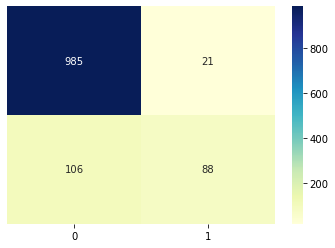

In [16]:
cf_matrix = confusion_matrix(y_test, y_pred)
# print(f"confusion matrix:\n {cf_matrix}") #\n means new line i.e. next line

# Visualise the confusion matrix as a Seaborn Heatmap
sns.heatmap(cf_matrix, annot=True, fmt="d", yticklabels=False, cmap="YlGnBu")

# If you want to save the graph to disk
# plt.tight_layout() # automatically adjusts subplot to fit in the figure area
# plt.savefig('confusion-matrix-initial.png', dpi=300) # dpi=300 is print quality


### c. Scikit-Learn's classification report

> ***Result***
> - Precision: the closer the precision is to 1.0, the better the model is. when it predicts that a person will take a loan, it is correct 81% of the time.
> - Recall: the closer the recall is to 1.0, the better the model is. Our model has a recall of 45% for loan-taker. This means that it can correctly identify 45% of all people who took a loan.
> - f1-score: the closer the f1 score is to 1.0, the better the model is. With a weighted f1 score of 0.88, our model does seem to be very promising.
> - Support: The third row shows the accuracy score of 0.89416 which is great
> - but it's misleading because the sample is unbalanced. 1006 observations for class 0 and only 194 for class 1

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1006
           1       0.81      0.45      0.58       194

    accuracy                           0.89      1200
   macro avg       0.86      0.72      0.76      1200
weighted avg       0.89      0.89      0.88      1200



### d. AUC and ROC curve

> ***Result***
> - the closer the AUC is to 1.0, the better the model is.
> - AUC is 0.72

AUC: 0.72


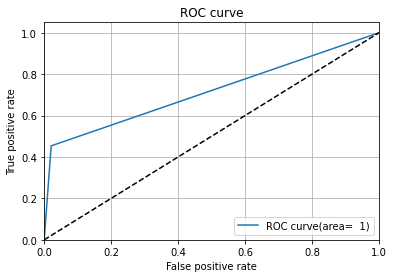

In [18]:
# Call function roc_curve() to get the false positive rates (fpr) and true positive rates
# Need to pass the list of actual and predicted classes as parameters to the function
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
#print(fpr)
#print(tpr)

# Call the auc() function to calculate the area under the curve
# Need to pass the false positive rates (fpr) and true positive rates as parameters to the function
roc_auc = auc(fpr,tpr)
print(f'AUC: {roc_auc:0.2f}') # float 2 places of decimal

# Plot ROC curve
plt.figure()
plt.plot(fpr,tpr,label='ROC curve(area= %2.f)' %roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
#plt.show()

# # If you want to save the graph to disk
# plt.tight_layout() # automatically adjusts subplot to fit in the figure area
# plt.savefig('roc-curve-initial.png', dpi=300) # dpi=300 is print quality

## 5. Pickling

In [19]:
# Pickle the model for later evaluation
joblib.dump(rf_model, 'model-random-forest.pkl')  # Use the right model name and a suitable file name

# Also need to pickle the training and testing sets
joblib.dump(X_train, 'X_train-rf.pkl') 
joblib.dump(X_test, 'X_test-rf.pkl') 
joblib.dump(y_train, 'y_train-rf.pkl') 
joblib.dump(y_test, 'y_test-rf.pkl')

# Note: make sure that the model and the training/testing sets match 
# i.e. the model was built using this particular training set
# and the testing set matches this particular training

['y_test-rf.pkl']

## 6. Summary of Hyper parameter tuning

 {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 30, 'min_samples_leaf': 7}, score: 0.69

accuracy before tuning: 0.8925 <br>
accuracy after tuning: 0.8941666666666667